# Project 4: Optimal Vehicle State Estimation

Max Schrader

In [1]:
# # !pip install scipy
# !pip install scipy
# !pip install plotly
# !pip install dubins
# !python -mpip install --only-binary numpy

In [2]:
import math
from dataclasses import dataclass
from typing import List
from IPython.display import display

import sympy
import dubins
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
from scipy.interpolate import interp2d
from scipy.stats import multivariate_normal

sympy.init_printing(use_latex='mathjax')
pio.templates.default = "ggplot2"
pio.renderers.default = "plotly_mimetype"

### Importing my code from ./src.py because I miss VSCode Intellisense

In [3]:
from src import Radar
from src import LTI
from src import EKFStep
from src import EKF

In [4]:
rad_to_deg = 180 / math.pi

## Finding Dubin's Path

In [5]:
R = 5  # given
dt = 0.01

In [6]:
q0 = (0, -15, -90 / rad_to_deg)
q1 = (-5, 20, -180 / rad_to_deg)
turning_radius = R
step_size = dt

path = dubins.shortest_path(q0, q1, R)
optimal_path, x = path.sample_many(step_size)

In [7]:
len(optimal_path)

5519

In [8]:
def plot_dubin(*args):
    fig = go.Figure()
    
    for name,  mode, path_list, in args:
        _x = [p[0] for p in path_list]
        _y = [p[1] for p in path_list]
        _theta = [p[2] * rad_to_deg for p in path_list]
        
        fig.add_trace(
            go.Scatter(
                x=_x,
                y=_y,
                text=_theta,
                name=name,
                mode=mode,
                hovertemplate="Angle: %{text}<br>X: %{x}<br>Y: %{y}"
            )
        )
        
        if "dubin" in name.lower():
            fig.add_trace(
                go.Scatter(
                    x=_x[::len(_x) - 1],
                    y=_y[::len(_y) - 1],
                    name="End Points",
                    mode="markers",
                    marker_size=8,
                    marker_color="black"
                )
            )
    
    fig.update_layout(
        margin=dict(l=20, r=20, b=20, t=20),
        height=600, width=600,
        yaxis=dict(scaleanchor="x", scaleratio=1),
        xaxis_zeroline=True,
        yaxis_zeroline=True,
        xaxis_zerolinecolor='#969696',
        yaxis_zerolinecolor='#969696',
        xaxis_range=[-25, 25],
        yaxis_range=[-25, 25],
    )
    
    return fig

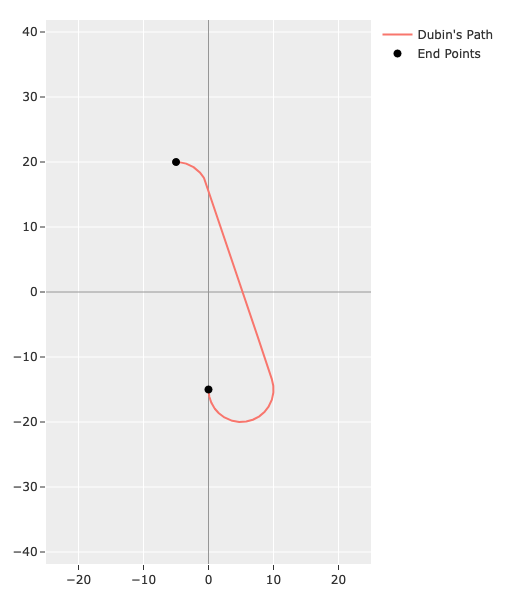

In [9]:
plot_dubin(["Dubin's Path", "lines", optimal_path]).show()

## Creating the Car Model

In [10]:
from sympy.abc import alpha, x, y, v, w, R, theta
from sympy import symbols, Matrix

In [11]:
d_t, s = symbols('dt, s')
a = Matrix([
    [x + d_t * s * sympy.cos(theta)],
    [y + d_t * s * sympy.sin(theta)],
    [theta]
])

A = a.jacobian(Matrix([x, y, theta]))

In [12]:
y_1, x_1, y_2, x_2 = symbols('y_1, x_1, y_2, x_2')
b = Matrix([
    [sympy.atan2((y - y_1), (x - x_1))],
    [sympy.atan2((y - y_2), (x - x_2))],
    [theta]
])
B = b.jacobian(Matrix([x, y, theta]))
B

⎡       -y + y₁                 x - x₁          ⎤
⎢─────────────────────  ─────────────────────  0⎥
⎢        2           2          2           2   ⎥
⎢(x - x₁)  + (y - y₁)   (x - x₁)  + (y - y₁)    ⎥
⎢                                               ⎥
⎢       -y + y₂                 x - x₂          ⎥
⎢─────────────────────  ─────────────────────  0⎥
⎢        2           2          2           2   ⎥
⎢(x - x₂)  + (y - y₂)   (x - x₂)  + (y - y₂)    ⎥
⎢                                               ⎥
⎣          0                      0            1⎦

### Calculating the True Vehicle Path

In [13]:
lti = LTI(s=1, s_var=0.05, dt=0.5, x0=optimal_path[0], dubins_path=optimal_path, q1=q1)
lti.x_t_noise(x=[np.array([optimal_path[0]])], )

#### Plotting the Path

In [14]:
simple_trajectory = [list(a[0]) for a in lti.trajectory]
# simple_trajectory

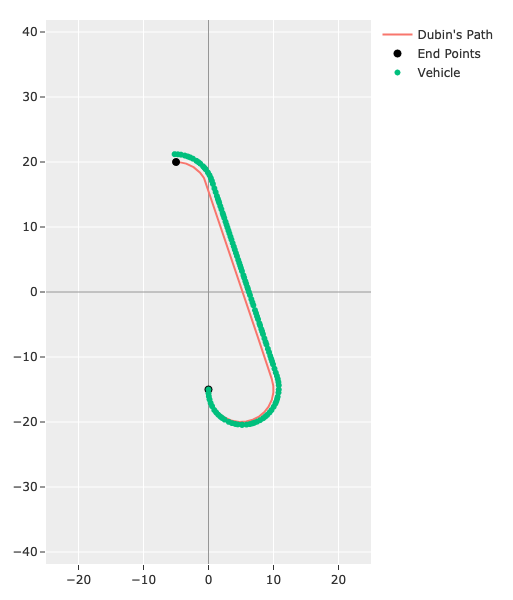

In [15]:
plot_dubin(["Dubin's Path", "lines", optimal_path], ["Vehicle", "markers", simple_trajectory]).show()

## Implementing a Simple, Noisy Bearing Calc

In [16]:
# I added in the distance from the radar to make plotting easier
def two_radar_est(lti: LTI, radar_1: Radar, radar_2: Radar) -> list:
    y = []
    f_var = multivariate_normal(mean=np.zeros(3), cov=np.diag([radar_1.v / (rad_to_deg) ** 2, radar_2.v / (rad_to_deg) ** 2, 5 / rad_to_deg]))
    for x in lti.trajectory:
        var = f_var.rvs()
        
        state = dict(x=x[0][0], 
                     y=x[0][1],
                     x1=radar_1.x, 
                     x2=radar_2.x,
                     y1=radar_1.y, 
                     y2=radar_2.y, 
                     theta=x[0][2])

        y_k = lti.measure(**state, noise_matrix=var)

        y_k = np.r_[
            y_k[0] * rad_to_deg, 
            np.linalg.norm(np.array(x[0][:-1]) - np.array((radar_1.x, radar_1.y))), 
            np.linalg.norm(np.array(x[0][:-1]) - np.array((radar_2.x, radar_2.y)))
           ]
        y.append(
            y_k
        )
    return y

### Radars at (−15, −10) and (−15, 5)

In [44]:
radar_1 = Radar(x=-15, y=-10, v=9)
radar_2 = Radar(x=-15, y=5, v=9)
bearing = two_radar_est(lti, Radar(x=-15, y=-10, v=9), Radar(x=-15, y=5, v=9))

#### Plotting the Bearing

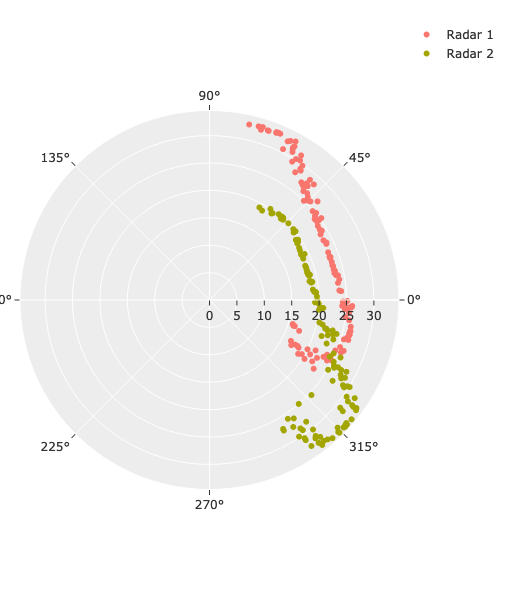

In [45]:
fig = go.Figure()

fig.add_trace(
    go.Scatterpolar(
        r = [b[3] for b in bearing],
        theta = [b[0] for b in bearing],
        mode = 'markers',
        name="Radar 1"
    )
)

fig.add_trace(
    go.Scatterpolar(
        r = [b[4] for b in bearing],
        theta = [b[1] for b in bearing],
        mode = 'markers',
        name="Radar 2"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    height=600, width=600,
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    xaxis_range=[-25, 25],
    yaxis_range=[-25, 25],
)

fig.show()

#### using the bearing and the distance to plot in XY

In [46]:
x_y_1 = [(radar_1.x + np.cos(b[0] / rad_to_deg) * b[3], radar_1.y + np.sin(b[0] / rad_to_deg) * b[3], b[2]) for b in bearing]
x_y_2 = [(radar_2.x + np.cos(b[1] / rad_to_deg) * b[4], radar_2.y + np.sin(b[1] / rad_to_deg) * b[4], b[2]) for b in bearing]

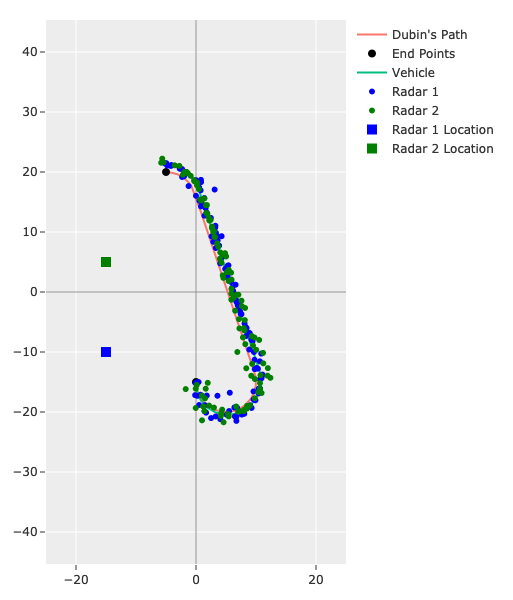

In [20]:
fig = plot_dubin(["Dubin's Path", "lines", optimal_path], 
           ["Vehicle", "lines", simple_trajectory], 
           ["Radar 1", "markers", x_y_1],
           ["Radar 2", "markers", x_y_2])

fig.data[3].line.color = "blue"
fig.data[4].line.color = "green"

fig.add_trace(
    go.Scatter(
        x=[radar_1.x],
        y=[radar_1.y],
        name='Radar 1 Location',
        mode="markers",
        marker_size=10,
        marker_color="blue",
        marker_symbol="square"
    )
)

fig.add_trace(
    go.Scatter(
        x=[radar_2.x],
        y=[radar_2.y],
        name='Radar 2 Location',
        mode="markers",
        marker_size=10,
        marker_color="green",
        marker_symbol="square"
    )
)


fig.show()

### Radars at (−100, −10) and (−100, 5)

In [21]:
radar_1 = Radar(x=-100, y=-10, v=9)
radar_2 = Radar(x=-100, y=5, v=9)
bearing = two_radar_est(lti, radar_1, radar_2)

#### Plotting the Bearing

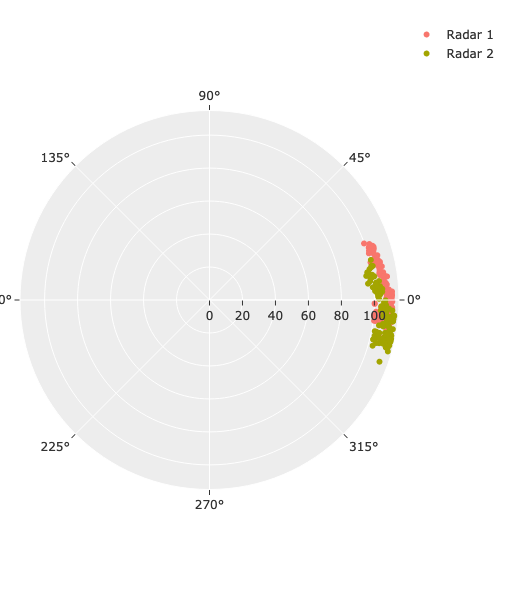

In [22]:
fig = go.Figure()

fig.add_trace(
    go.Scatterpolar(
        r = [b[3] for b in bearing],
        theta = [b[0] for b in bearing],
        mode = 'markers',
        name="Radar 1"
    )
)

fig.add_trace(
    go.Scatterpolar(
        r = [b[4] for b in bearing],
        theta = [b[1] for b in bearing],
        mode = 'markers',
        name="Radar 2"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    height=600, width=600,
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    xaxis_range=[-25, 25],
    yaxis_range=[-25, 25],
)

fig.show()

#### using the bearing and the distance to plot in XY

In [23]:
x_y_1 = [(radar_1.x + np.cos(b[0] / rad_to_deg) * b[3], radar_1.y + np.sin(b[0] / rad_to_deg) * b[3], b[2]) for b in bearing]
x_y_2 = [(radar_2.x + np.cos(b[1] / rad_to_deg) * b[4], radar_2.y + np.sin(b[1] / rad_to_deg) * b[4], b[2]) for b in bearing]

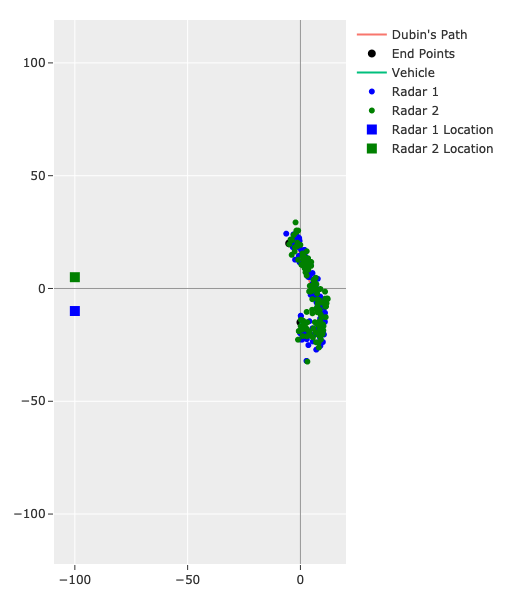

In [24]:
fig = plot_dubin(["Dubin's Path", "lines", optimal_path], 
           ["Vehicle", "lines", simple_trajectory], 
           ["Radar 1", "markers", x_y_1],
           ["Radar 2", "markers", x_y_2])

fig.data[3].line.color = "blue"
fig.data[4].line.color = "green"

fig.add_trace(
    go.Scatter(
        x=[radar_1.x],
        y=[radar_1.y],
        name='Radar 1 Location',
        mode="markers",
        marker_size=10,
        marker_color="blue",
        marker_symbol="square"
    )
)

fig.add_trace(
    go.Scatter(
        x=[radar_2.x],
        y=[radar_2.y],
        name='Radar 2 Location',
        mode="markers",
        marker_size=10,
        marker_color="green",
        marker_symbol="square"
    )
)


fig.update_layout(
    xaxis_range=None,
    yaxis_range=None
)


fig.show()

## Estimate the Postition of the Ground Vehicle Using EKFs

### Radar at (−15, −10) and (−15, 5)

In [56]:
# Givens
dt = 0.5
R = 5
radar_1 = Radar(x=-15, y=-10, v=9)
radar_2 = Radar(x=-15, y=5, v=9)

lti = LTI(s=1, s_var=0.05, dt=dt,
          x0=optimal_path[0], dubins_path=optimal_path, q1=q1)

lti.x_t_noise(x=[np.array([optimal_path[0]])], )

e = EKF(lti, 
        R=np.diag([radar_1.v / (rad_to_deg ** 2), radar_2.v / (rad_to_deg ** 2), 5 / (rad_to_deg ** 2)]),
        Q=np.diag([0.05, 0.05, (1 / R) ** 2 * dt ** 2]), radars=(radar_1, radar_2))

res_close = e.run("silent")

### Radar at (−100, −10) and (−100, 5)

In [57]:
# Givens
dt = 0.5
R = 5
radar_1 = Radar(x=-100, y=-10, v=9)
radar_2 = Radar(x=-100, y=5, v=9)

lti = LTI(s=1, s_var=0.05, dt=dt,
          x0=optimal_path[0], dubins_path=optimal_path, q1=q1)

lti.x_t_noise(x=[np.array([optimal_path[0]])], )

e = EKF(lti, 
        R=np.diag([radar_1.v / (rad_to_deg ** 2), radar_2.v / (rad_to_deg ** 2), 5 / (rad_to_deg ** 2)]),
        Q=np.diag([0.05, 0.05, (1 / R) ** 2 * dt ** 2]), radars=(radar_1, radar_2))

res_far = e.run("silent")

### Plotting Computed Path vs. "Actual" Trajectory

In [60]:
# [r.x_k_k.T[0] for r in res_close]

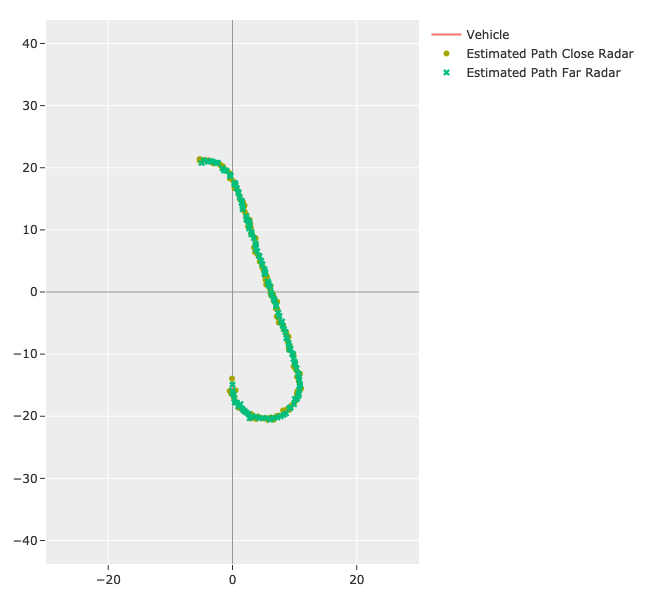

In [63]:
fig = plot_dubin( 
                 ["Vehicle", "lines", simple_trajectory],
                 # ["Radar 1", "markers", x_y_1],
                 # ["Radar 2", "markers", x_y_2],
                 ["Estimated Path Close Radar", "markers", [r.x_k_k.T[0] for r in res_close]],
                 ["Estimated Path Far Radar", "markers", [r.x_k_k.T[0] for r in res_far]]

)

fig.data[-1].marker.symbol = "x"

fig.show()

### Plotting _a posteriori_ states

#### $\hat{x}_{k|k}$

In [73]:
t = [i * dt for i in range(len(res_close))]
x_k_k_close = [r.x_k_k.T[0][0] for r in res_close]
x_act = [x[0] for x in simple_trajectory]
x_std_close = [r.P_k_k[0][0] ** (1 / 2) * 2 for r in res_close]

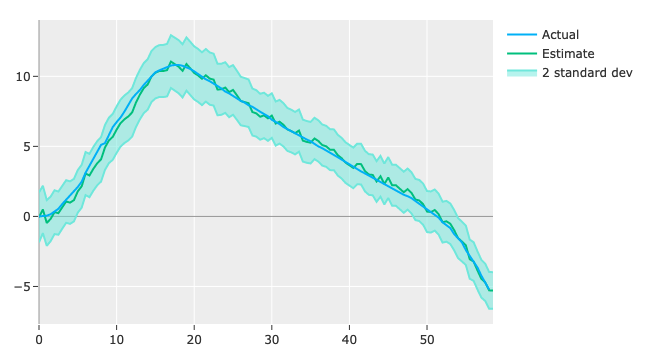

In [88]:
fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='tonexty',
        line_color='rgb(111, 231, 219)',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='',
        fill='tonexty',
        line_color='rgb(111, 231, 219)',
        name="2 standard dev"
    )
)


fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_close,
        name="Estimate"
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=x_act,
        name="Actual"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

#### $\hat{y}_{k|k}$

In [89]:
t = [i * dt for i in range(len(res_close))]
x_k_k_close = [r.x_k_k.T[0][1] for r in res_close]
x_act = [x[1] for x in simple_trajectory]
x_std_close = [r.P_k_k[1][1] ** (1 / 2) * 2 for r in res_close]

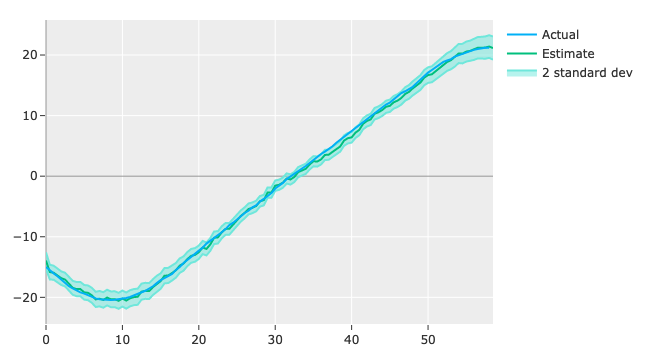

In [90]:
fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='tonexty',
        line_color='rgb(111, 231, 219)',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='',
        fill='tonexty',
        line_color='rgb(111, 231, 219)',
        name="2 standard dev"
    )
)


fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_close,
        name="Estimate"
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=x_act,
        name="Actual"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

#### $\hat{\theta}_{k|k}$

In [93]:
t = [i * dt for i in range(len(res_close))]
x_k_k_close = [r.x_k_k.T[0][2] * rad_to_deg for r in res_close]
x_act = [x[2] * rad_to_deg for x in simple_trajectory]
x_std_close = [r.P_k_k[2][2] ** (1 / 2) * 2 *rad_to_deg for r in res_close]

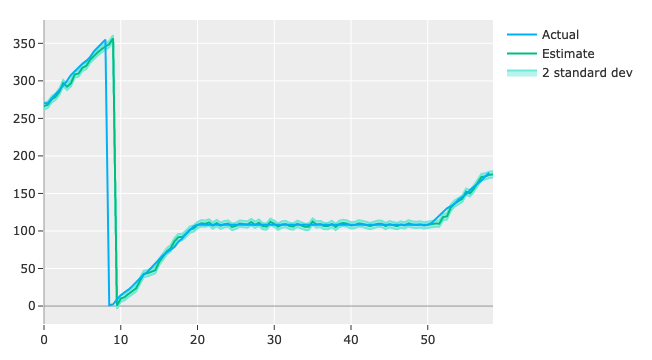

In [94]:
fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='tonexty',
        line_color='rgb(111, 231, 219)',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='',
        fill='tonexty',
        line_color='rgb(111, 231, 219)',
        name="2 standard dev"
    )
)


fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_close,
        name="Estimate"
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=x_act,
        name="Actual"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

### Plotting the Innovation

In [ ]:
t = [i * dt for i in range(len(res_close))]
x_k_k_close = [r.y_k.T[0][2] * rad_to_deg for r in res_close]
x_act = [x[2] * rad_to_deg for x in simple_trajectory]
x_std_close = [r.P_k_k[2][2] ** (1 / 2) * 2 *rad_to_deg for r in res_close]

In [96]:
res_close[0].y_k

array([[ 0.1264407 , -0.01963987, -0.06658291]])

In [97]:
res_close[0].S_k

array([[0.00704156, 0.002344  , 0.01      ],
       [0.002344  , 0.00467756, 0.016     ],
       [0.01      , 0.016     , 1.01152309]])